In [1]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.pipeline.signal as ps
import toolkit.analysis.spectrum as spec
import toolkit.plots.plots as plots
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

In [2]:
from toolkit.utils.module import reload_module

In [3]:
# SessionDirectory = reload_module('toolkit.pipeline.data_io', 'SessionDirectory')

## Parameters for the script

In [4]:
params = dict(
    group_width = 1,  # Number of channels to the left and right of the central channel
    psd_tseg = 0.5,  # segment duration in seconds
    df = 1.0  # frequency resolution in Hz
)

## Get session and load data

In [5]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']

session_dir = SessionDirectory(session_id, ecephys_structure_acronym, cache_lfp=True)

probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

session = session_dir.session

ValueError: Session 839557629 has no LFP data

In [6]:
group_width = params['group_width']

lfp_groups, channel_groups = ps.get_lfp_channel_groups(
    session_dir, probe_info['central_channels'], width=group_width
)

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
c:\Users\ziaochen\.conda\envs\neuro2\lib\site-pa

## Analyze data

In [7]:
stimulus_presentations = session.stimulus_presentations
session_type = session.session_type

stimulus_names = st.STIMULUS_NAMES[session_type]
drifting_gratings_stimuli = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings']

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


#### Process PSD

In [8]:
psd_tseg = params['psd_tseg']
df = params['df']

psd_das = {}
cond_psd_das = {}

for stim in stimulus_names:
    stim_trials = st.get_stimulus_trials(stimulus_presentations, stimulus_name=stim)
    aligned_lfp = st.align_trials(lfp_groups, stim_trials, window=(0., stim_trials.duration))
    psd_trials = ps.trial_psd(aligned_lfp, tseg=psd_tseg, df=df)
    psd_avg = psd_trials.mean(dim='presentation_id', keep_attrs=True)
    psd_das[stim] = psd_avg

    if stim in drifting_gratings_stimuli:  # has conditions
        conditions = st.presentation_conditions(stim_trials.presentations, condition_types=st.CONDITION_TYPES)
        cond_psd = st.average_across_conditions(psd_trials, *conditions)
        cond_psd_das[stim] = cond_psd

#### Save output data

In [9]:
# Save PSD of stimuli
session_dir.save_psd(psd_das, channel_groups)

# Save conditions PSD of drifting gratings
session_dir.save_conditions_psd(cond_psd_das)

## Visualize PSDs

In [10]:
plt_range = 100.
fit_freq_range = 200.
aperiodic_mode = 'knee'

wave_band_limit = GLOBAL_SETTINGS['wave_band_limit'].copy()
wave_band_width_limit = GLOBAL_SETTINGS['wave_band_width_limit'].copy()

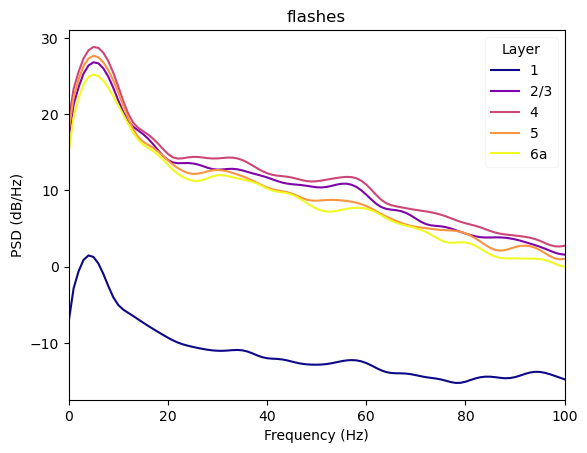

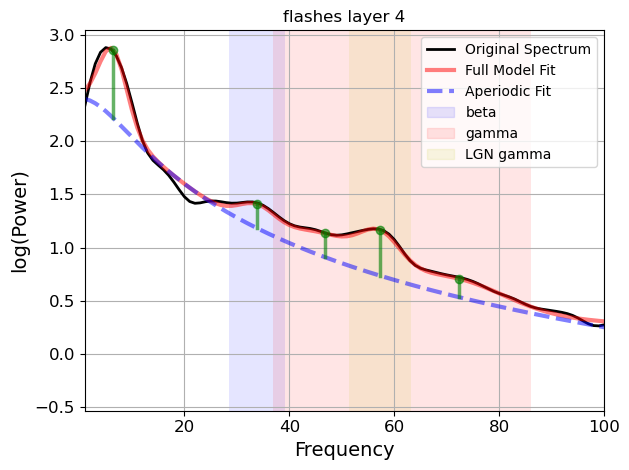

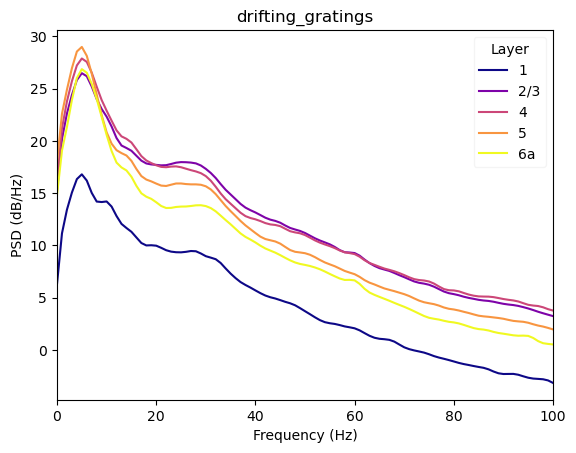

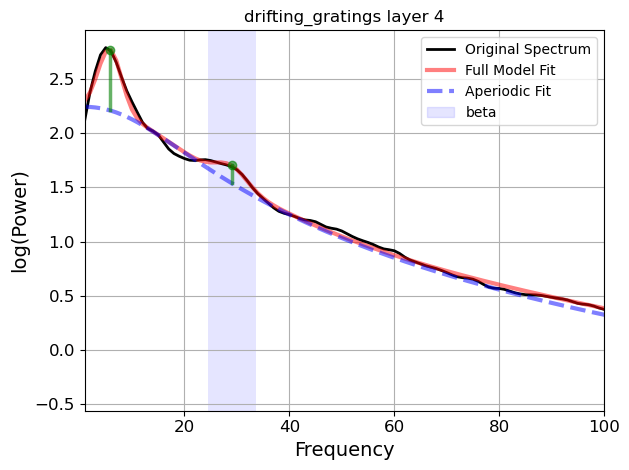

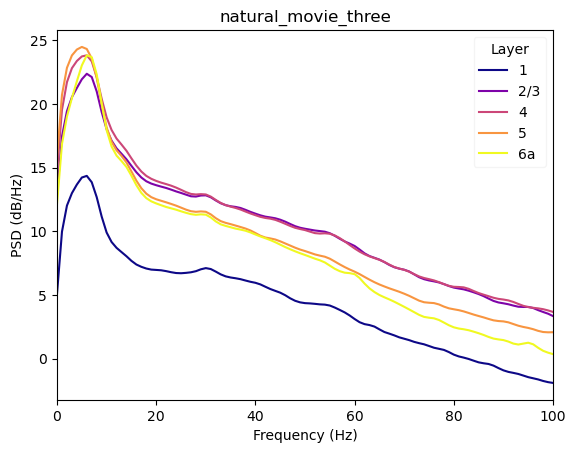

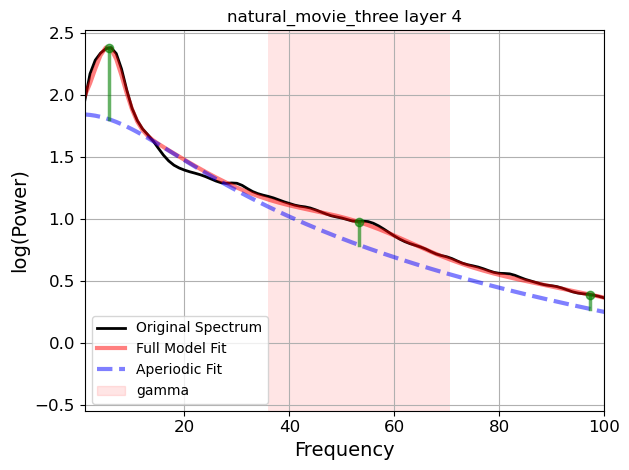

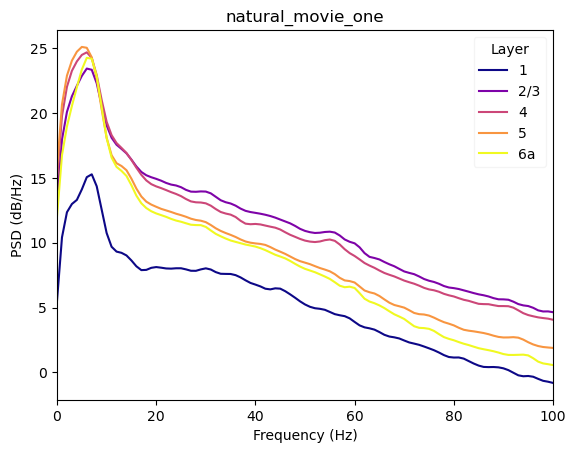

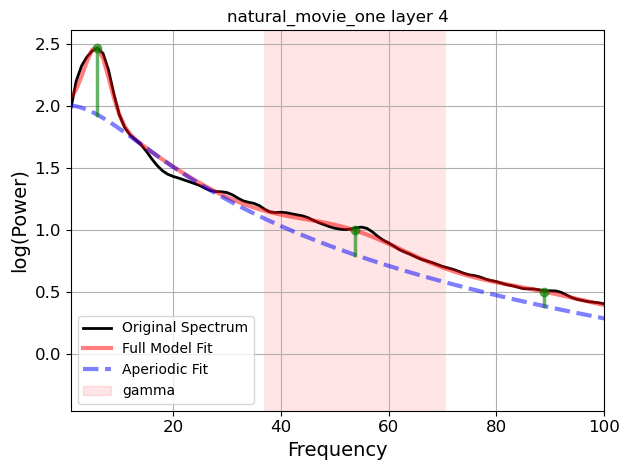

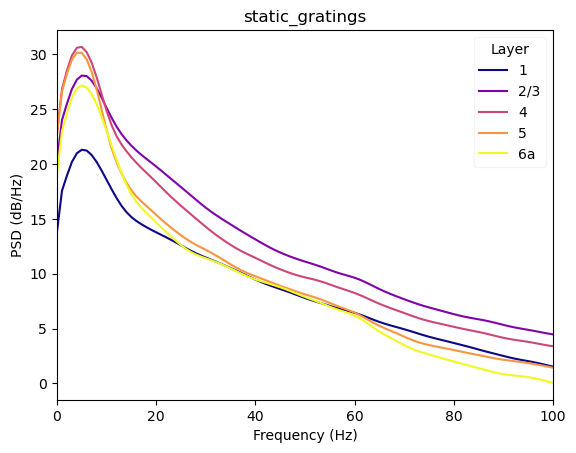

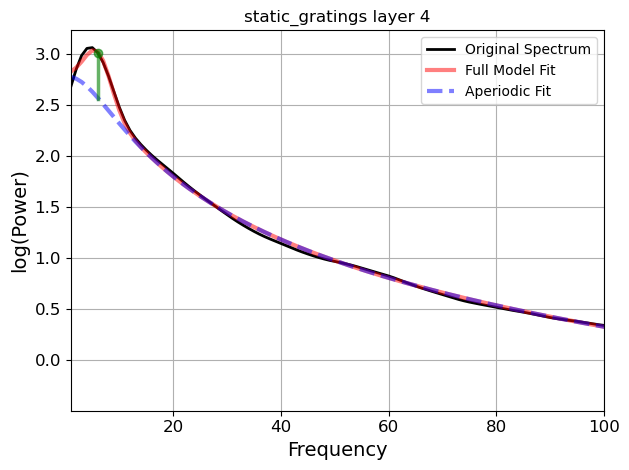

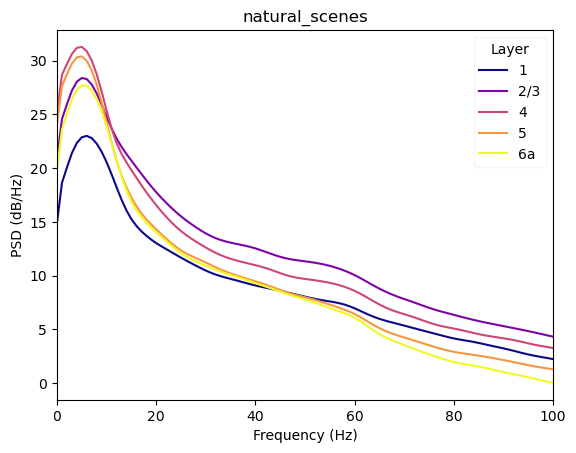

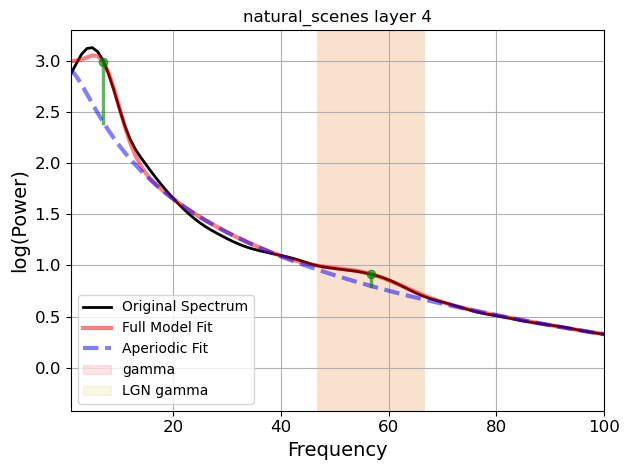

In [11]:
plt_layer = '5'

for stim in stimulus_names:
    psd_avg = psd_das[stim]
    ax = plots.plot_channel_psd(psd_avg, channel_dim='layer', freq_range=plt_range)
    ax.set_title(stim)

    psd_da = psd_avg.sel(layer=plt_layer)
    fooof_result = spec.fit_fooof(psd_da,
        freq_range=fit_freq_range, aperiodic_mode=aperiodic_mode,
        max_n_peaks=10, dB_threshold=0.8, peak_threshold=1.)
    _, ax = plt.subplots(1, 1)
    ax = plots.plot_fooof_quick(fooof_result[1], freq_range=plt_range, ax=ax)

    bands = []
    for band_name, band in wave_band_limit.items():
        bands.append(spec.get_fooof_freq_band(
            fooof_result[0], band, width_limit=wave_band_width_limit[band_name],
            top_n_peaks=2, bandwidth_n_sigma=1.5
        )[0])

    # ax = plots.plot_fooof(psd_da, fooof_result=fooof_result[0], freq_range=plt_range)
    ax = plots.plot_freq_band(bands, list(wave_band_limit), ax=ax)
    ax.set_title(f"{stim} layer {plt_layer}")

    plt.show()

In [ ]:
# st = reload_module('toolkit.allen_helpers.stimuli')
# trial_psd = reload_module('toolkit.pipeline.signal', 'trial_psd')
# plots = reload_module(plots)
# get_fooof_freq_band = reload_module('toolkit.analysis.spectrum', 'get_fooof_freq_band')